<center><h1>HW2</h1></center>
<br>
<br>

Name: Vivek Lakhani
<br>
Github Username: vivek-lakhani-1
<br>
USC ID: 8836256233

## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

In [1]:
# !pip install matplotlib numpy pandas seaborn scipy scikit-learn tabulate statsmodels
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import math
from scipy.io import arff
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from tabulate import tabulate
import statsmodels.api as sm
warnings.filterwarnings("ignore")
from itertools import combinations

Get the Cycle Power Plant Data Set

### (b) Exploring the data

#### i. rows and columns

In [2]:
df_ccpp_data = pd.read_excel(r'../data/CCPP/Folds5x2_pp.ods',engine="odf")

print("\nPreviewing of Dataset CCPP:")
print(df_ccpp_data.head())

total_ent, total_fea = df_ccpp_data.shape
print(f"\nTotal Records: {total_ent}")
print(f"Total Attributes: {total_fea}")

feature_names = df_ccpp_data.columns.tolist()
print("\nFeature Labels:", feature_names)

feature_details = [
    ["T", "Temp", "Average hourly ambient temperature (°C)"],
    ["AP", "Air Pressure", "Mean atmospheric pressure recorded per hour (millibars)"],
    ["RH", "Moisture Level", "Mean relative humidity percentage per hour"],
    ["V", "Exhaust Pressure", "Mean vacuum pressure measured hourly (cm Hg)"],
    ["EP", "Energy Generation", "Total electricity output per hour (MW)"]
]

print("\nFeature Overview:")
print(tabulate(feature_details, headers=["Attribute", "Label", "Description"], tablefmt="grid"))



Previewing of Dataset CCPP:
      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90

Total Records: 9568
Total Attributes: 5

Feature Labels: ['AT', 'V', 'AP', 'RH', 'PE']

Feature Overview:
+-------------+-------------------+---------------------------------------------------------+
| Attribute   | Label             | Description                                             |
+=============+===================+=========================================================+
| T           | Temp              | Average hourly ambient temperature (°C)                 |
+-------------+-------------------+---------------------------------------------------------+
| AP          | Air Pressure      | Mean atmospheric pressure recorded per hour (millibars) |
+-------------+-------------------+-------------------------

#### ii. pairwise scatterplots of all the varianbles

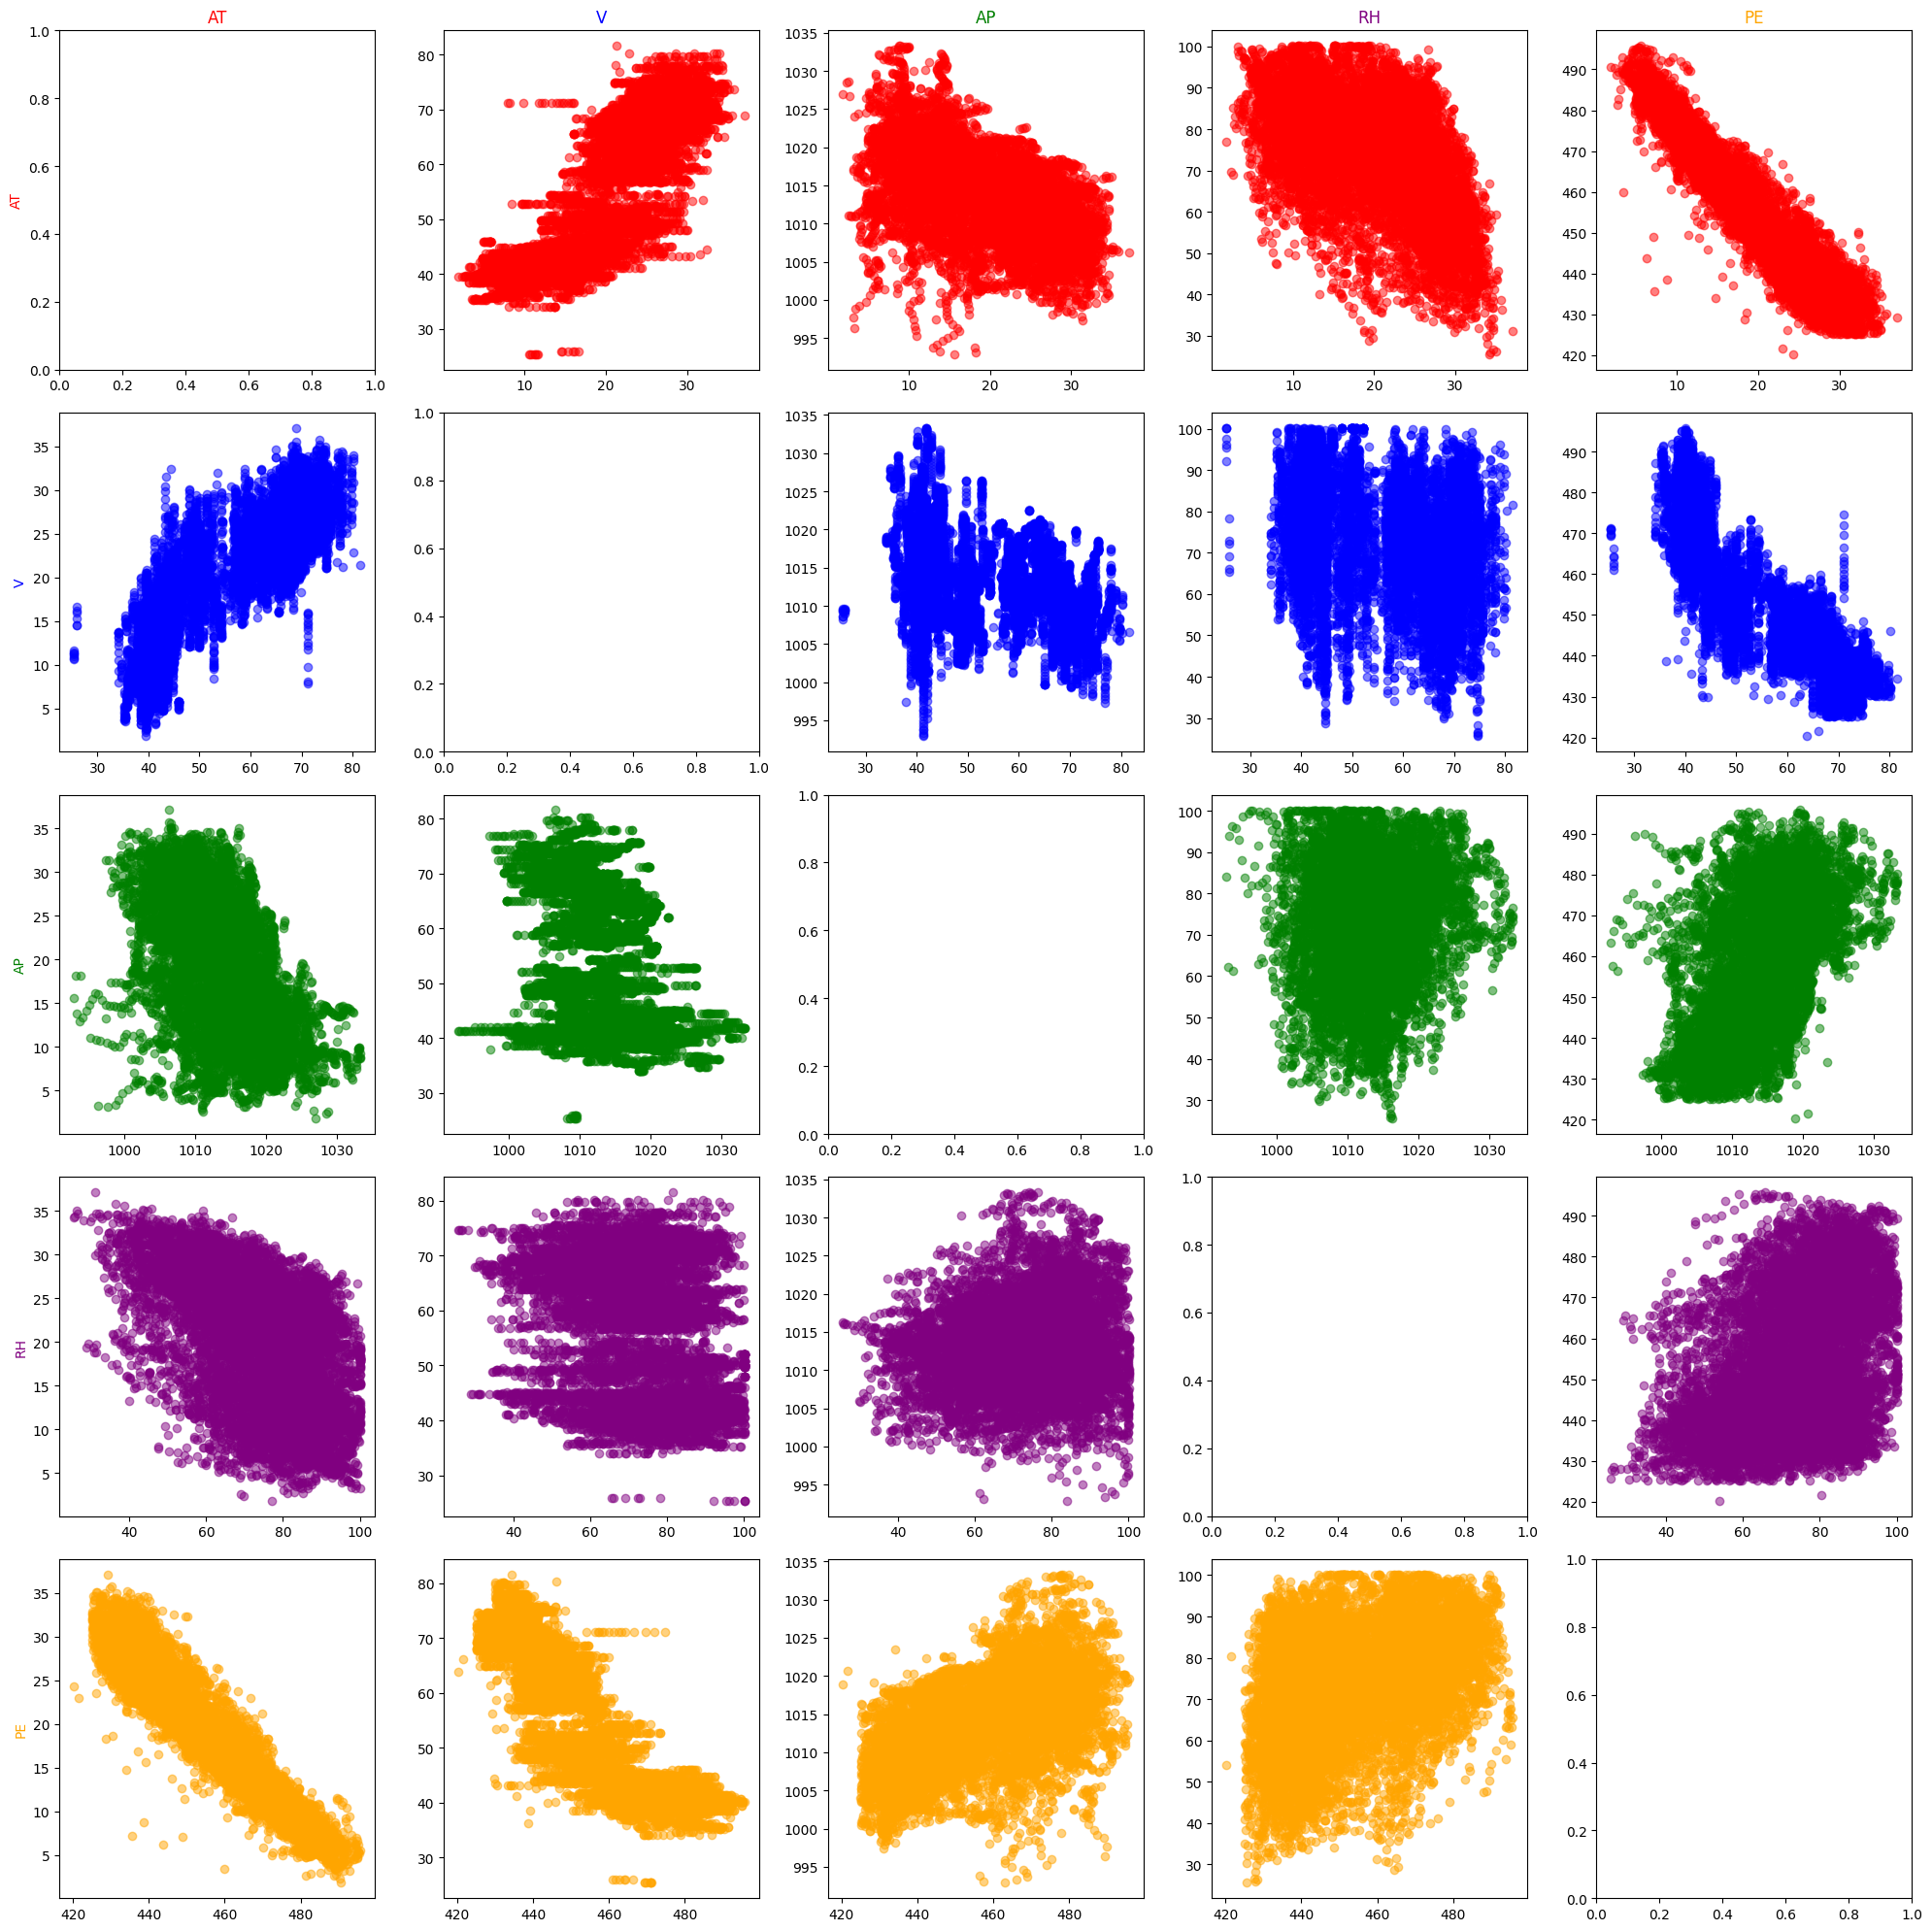

In [3]:
data_values = df_ccpp_data.to_numpy()
feature_headers = df_ccpp_data.columns.tolist()

fig, plot_grid_data = plt.subplots(5, 5, figsize=(20, 20))
color_palette = ['red', 'blue', 'green', 'purple', 'orange']

for row_idx in range(5):
    for col_idx in range(5):
        if row_idx != col_idx:
            plot_grid_data[row_idx, col_idx].scatter(
                data_values[:, row_idx], 
                data_values[:, col_idx], 
                alpha=0.5, 
                color=color_palette[row_idx % len(color_palette)]
            )

        if col_idx == 0:
            plot_grid_data[row_idx, col_idx].set_ylabel(
                feature_headers[row_idx], color=color_palette[row_idx % len(color_palette)]
            )
        if row_idx == 0:
            plot_grid_data[row_idx, col_idx].set_title(
                feature_headers[col_idx], color=color_palette[col_idx % len(color_palette)]
            )

plt.tight_layout()
plt.show()


Observation:

1.Increased temperature leads to a decrease in energy production.
2.Increasing atmospheric pressure contributes to an increase in energy production. Pressure leads to a lower energy production.
3.There is a strong correlation between temperature and vacuum pressure.

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [4]:
stats_summary = pd.DataFrame({
    "Avg Value": df_ccpp_data.mean(),
    "Middle Value": df_ccpp_data.median(),
    "Minimum": df_ccpp_data.min(),
    "Maximum": df_ccpp_data.max(),
    "Value Range": df_ccpp_data.max() - df_ccpp_data.min(),
    "25th Percentile": df_ccpp_data.quantile(0.25),
    "75th Percentile": df_ccpp_data.quantile(0.75),
    "Interquartile Spread": df_ccpp_data.quantile(0.75) - df_ccpp_data.quantile(0.25)
})

print("\nDataset Statistical Overview:\n")
print(stats_summary.to_markdown())



Dataset Statistical Overview:

|    |   Avg Value |   Middle Value |   Minimum |   Maximum |   Value Range |   25th Percentile |   75th Percentile |   Interquartile Spread |
|:---|------------:|---------------:|----------:|----------:|--------------:|------------------:|------------------:|-----------------------:|
| AT |     19.6512 |         20.345 |      1.81 |     37.11 |         35.3  |           13.51   |             25.72 |                12.21   |
| V  |     54.3058 |         52.08  |     25.36 |     81.56 |         56.2  |           41.74   |             66.54 |                24.8    |
| AP |   1013.26   |       1012.94  |    992.89 |   1033.3  |         40.41 |         1009.1    |           1017.26 |                 8.16   |
| RH |     73.309  |         74.975 |     25.56 |    100.16 |         74.6  |           63.3275 |             84.83 |                21.5025 |
| PE |    454.365  |        451.55  |    420.26 |    495.76 |         75.5  |          439.75   |            4

### (c) Simple Linear Regression

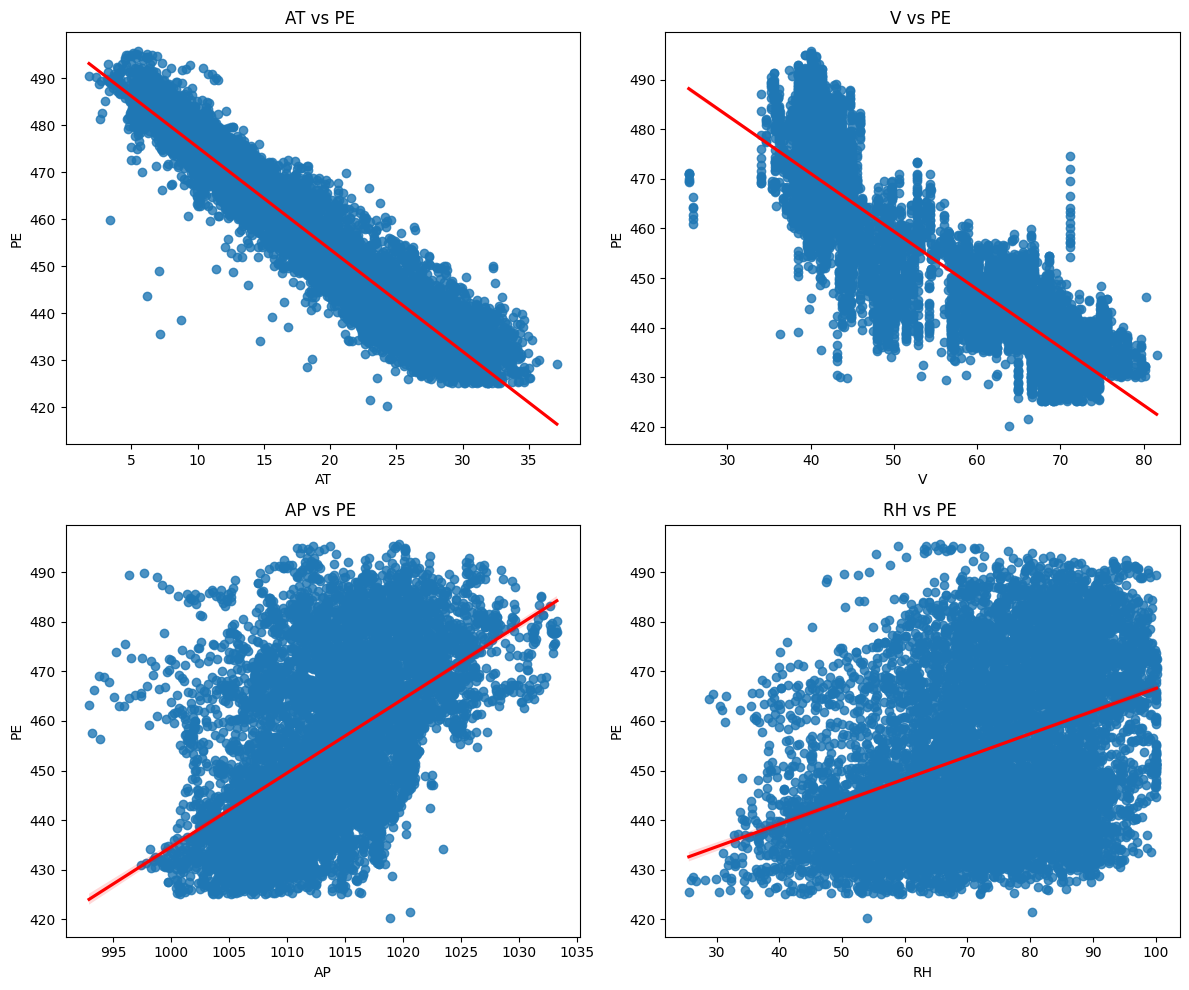

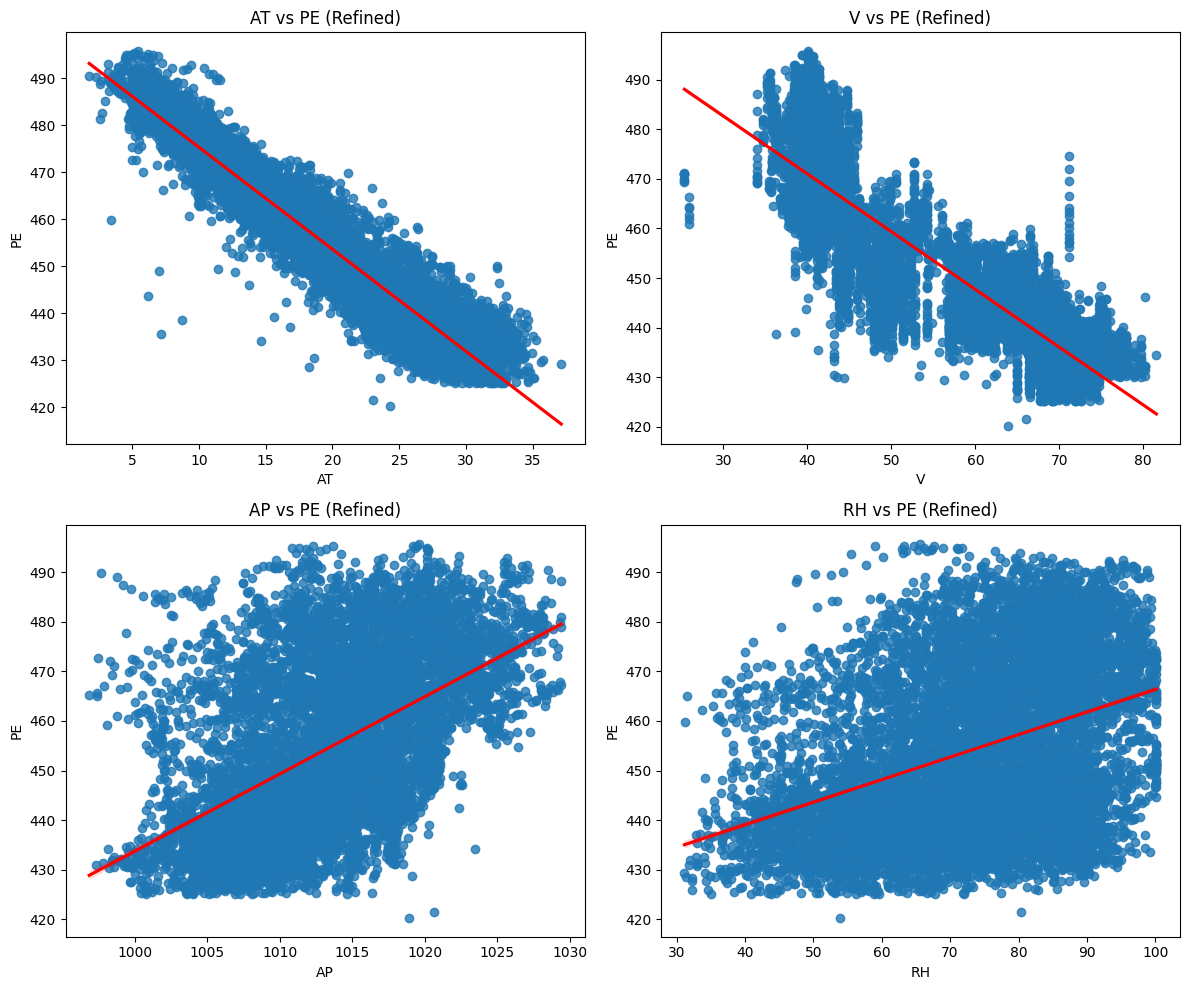

  Feature  R² (Before Refinement)  R² (After Refinement)  P-Value (Before)  P-Value (After)
0      AT                0.898948               0.897835               0.0              0.0
1       V                0.756518               0.754784               0.0              0.0
2      AP                0.268769               0.271993               0.0              0.0
3      RH                0.151939               0.150938               0.0              0.0


In [5]:
input_features, target_output = df_ccpp_data.columns[:-1], df_ccpp_data.columns[-1]

def run_regression(dataframe, subtitle=""):
    regression_models = {}
    fig, plot_axes = plt.subplots(2, 2, figsize=(12, 10))
    plot_axes = plot_axes.flatten()
    
    for index, feature in enumerate(input_features):
        x_variable, y_variable = dataframe[feature], dataframe[target_output]
        x_variable = sm.add_constant(x_variable)
        model = sm.OLS(y_variable, x_variable).fit()
        regression_models[feature] = model

        sns.regplot(x=dataframe[feature], y=dataframe[target_output], ax=plot_axes[index], line_kws={"color": "red"})
        plot_axes[index].set_title(f"{feature} vs {target_output} {subtitle}")
        plot_axes[index].set_xlabel(feature)
        plot_axes[index].set_ylabel(target_output)
    
    plt.tight_layout()
    plt.show()
    return regression_models

initial_regression_results = run_regression(df_ccpp_data)

refined_data = df_ccpp_data.copy()
for feature in input_features:
    first_quartile, third_quartile = df_ccpp_data[feature].quantile([0.25, 0.75])
    interquartile_range = third_quartile - first_quartile
    refined_data = refined_data[
        (refined_data[feature] >= first_quartile - 1.5 * interquartile_range) & 
        (refined_data[feature] <= third_quartile + 1.5 * interquartile_range)
    ]

filtered_regression_results = run_regression(refined_data, "(Refined)")

regression_comparison = pd.DataFrame({
    "Feature": input_features,
    "R² (Before Refinement)": [initial_regression_results[f].rsquared for f in input_features],
    "R² (After Refinement)": [filtered_regression_results[f].rsquared for f in input_features],
    "P-Value (Before)": [initial_regression_results[f].pvalues[1] for f in input_features],
    "P-Value (After)": [filtered_regression_results[f].pvalues[1] for f in input_features]
})

print(regression_comparison.to_string())


AT and V stand out as the strongest predictors. All four variables have extremely small p-values for their coefficients, confirming the rejection of the null hypothesis. While the Temperature graph shows a few outliers, they have little impact on the overall results.

### (d) Multiple Regression

In [6]:
X_fs = df_ccpp_data.iloc[:, :-1]
y_tg = df_ccpp_data.iloc[:, -1]

X_fs = sm.add_constant(X_fs)
ols_model = sm.OLS(y_tg, X_fs).fit()

print(ols_model.summary())

important_features = ols_model.pvalues[ols_model.pvalues < 0.05].index.tolist()
print("Key Influencing Features (Reject H0):", important_features)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Sun, 23 Feb 2025   Prob (F-statistic):               0.00
Time:                        13:46:19   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

for all of the variables we can reject the null hypothesis.

### (e) 1c Compare to 1d

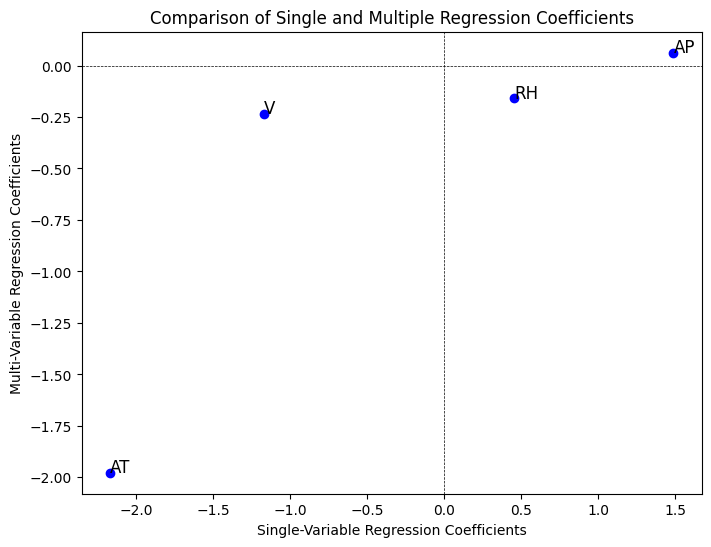

In [7]:
single_var_coeffs = {feature: initial_regression_results[feature].params[1] for feature in input_features}
multi_var_coeffs = {feature: ols_model.params[feature] for feature in input_features}

plt.figure(figsize=(8, 6))
plt.scatter(list(single_var_coeffs.values()), list(multi_var_coeffs.values()), color='blue')


for feature in input_features:
    plt.text(single_var_coeffs[feature], multi_var_coeffs[feature], feature, fontsize=12)


plt.xlabel("Single-Variable Regression Coefficients")
plt.ylabel("Multi-Variable Regression Coefficients")
plt.title("Comparison of Single and Multiple Regression Coefficients")


plt.axhline(0, color='black', linewidth=0.5, linestyle="--")
plt.axvline(0, color='black', linewidth=0.5, linestyle="--")


plt.show()


The coefficient for AT remains nearly unchanged, while the other three variables have increased significantly.

### (f) Nonlinear Association

In [8]:
# Fit nonlinear regression models for each predictor
nonlinear_regression_results = {}

for predictor in input_features:
    X = df_ccpp_data[predictor]
    y = df_ccpp_data[target_output]
    
    # Create X, X^2, and X^3
    X_poly = pd.DataFrame({
        'const': 1,
        predictor: X,
        f'{predictor}^2': X**2,
        f'{predictor}^3': X**3
    })
    
    model = sm.OLS(y, X_poly).fit()
    nonlinear_regression_results[predictor] = model.summary()

# Print nonlinear regression results for each predictor
for predictor, result in nonlinear_regression_results.items():
    print("---"*44)
    print("---"*44)
    print(f"Nonlinear regression results for {predictor}:")
    print(result)
    print("---"*44)
    print("---"*44)


------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------
Nonlinear regression results for AT:
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Sun, 23 Feb 2025   Prob (F-statistic):               0.00
Time:                        13:46:19   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                            

The feature RH exhibits nonlinearity. Although the p-values are low, the coefficient values remain quite small.

### (g) Interactions of Predictors

In [9]:
interaction_effects = {f"{feat1}*{feat2}": df_ccpp_data[feat1] * df_ccpp_data[feat2] 
                       for feat1, feat2 in combinations(input_features, 2)}


X_interact = df_ccpp_data[input_features].copy()
for term, values in interaction_effects.items():
    X_interact[term] = values

X_interact = sm.add_constant(X_interact)
y_values = df_ccpp_data[target_output]


interaction_reg_model = sm.OLS(y_values, X_interact).fit()
important_interactions = interaction_reg_model.pvalues[interaction_reg_model.pvalues < 0.05].index.tolist()

print(interaction_reg_model.summary())
print("Noteworthy Interaction Terms:", important_interactions)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Sun, 23 Feb 2025   Prob (F-statistic):               0.00
Time:                        13:46:19   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.7825     78.640      8.721      0.0

It is important to note that some of the original linear terms are now insignificant, with only V remaining statistically significant

### (h) Improvement

In [10]:
train_set, test_set = train_test_split(df_ccpp_data, test_size=0.3, random_state=42)

X_train_data, y_train_data = train_set.iloc[:, :-1], train_set.iloc[:, -1]
X_test_data, y_test_data = test_set.iloc[:, :-1], test_set.iloc[:, -1]

X_train_poly = X_train_data.copy()
X_test_poly = X_test_data.copy()
for feature in input_features:
    X_train_poly[f"{feature}^2"] = X_train_data[feature] ** 2
    X_test_poly[f"{feature}^2"] = X_test_data[feature] ** 2

X_train_poly = sm.add_constant(X_train_poly)
X_test_poly = sm.add_constant(X_test_poly)

quad_reg_model = sm.OLS(y_train_data, X_train_poly).fit()

significant_features = quad_reg_model.pvalues[quad_reg_model.pvalues < 0.05].index.tolist()
X_train_reduced = X_train_poly[significant_features]
X_test_reduced = X_test_poly[significant_features]

optimized_model = sm.OLS(y_train_data, X_train_reduced).fit()

y_train_estimates = optimized_model.predict(X_train_reduced)
y_test_estimates = optimized_model.predict(X_test_reduced)

mse_train = mean_squared_error(y_train_data, y_train_estimates)
mse_test = mean_squared_error(y_test_data, y_test_estimates)

print(optimized_model.summary())
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.429e+04
Date:                Sun, 23 Feb 2025   Prob (F-statistic):               0.00
Time:                        13:46:19   Log-Likelihood:                -19218.
No. Observations:                6697   AIC:                         3.845e+04
Df Residuals:                    6689   BIC:                         3.851e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.13e+04   1097.235    -10.298      0.0

### (i) KNN

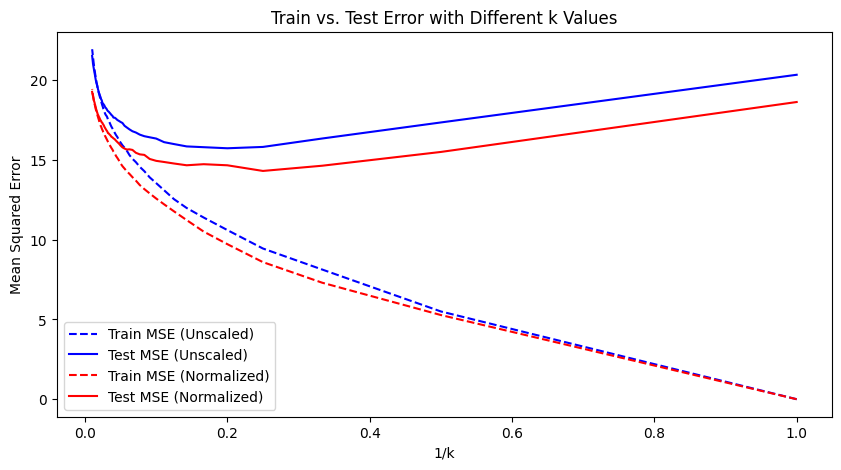

Best k for normalized features: 4
Best k for unscaled features: 5


In [11]:
X_data = df_ccpp_data.iloc[:, :-1].values
y_values = df_ccpp_data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X_data, y_values, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k_range = range(1, 101)
mse_train_original = []
mse_test_original = []
mse_train_scaled = []
mse_test_scaled = []

for k in k_range:
    knn_original = KNeighborsRegressor(n_neighbors=k)
    knn_standardized = KNeighborsRegressor(n_neighbors=k)

    knn_original.fit(X_train, y_train)
    knn_standardized.fit(X_train_scaled, y_train)

    y_train_pred_original = knn_original.predict(X_train)
    y_test_pred_original = knn_original.predict(X_test)

    y_train_pred_scaled = knn_standardized.predict(X_train_scaled)
    y_test_pred_scaled = knn_standardized.predict(X_test_scaled)

    mse_train_original.append(mean_squared_error(y_train, y_train_pred_original))
    mse_test_original.append(mean_squared_error(y_test, y_test_pred_original))

    mse_train_scaled.append(mean_squared_error(y_train, y_train_pred_scaled))
    mse_test_scaled.append(mean_squared_error(y_test, y_test_pred_scaled))

plt.figure(figsize=(10, 5))
plt.plot(1 / np.array(k_range), mse_train_original, label='Train MSE (Unscaled)', linestyle="--", color="blue")
plt.plot(1 / np.array(k_range), mse_test_original, label='Test MSE (Unscaled)', linestyle="-", color="blue")
plt.plot(1 / np.array(k_range), mse_train_scaled, label='Train MSE (Normalized)', linestyle="--", color="red")
plt.plot(1 / np.array(k_range), mse_test_scaled, label='Test MSE (Normalized)', linestyle="-", color="red")
plt.xlabel('1/k')
plt.ylabel('Mean Squared Error')
plt.title('Train vs. Test Error with Different k Values')
plt.legend()
plt.show()

best_k_scaled = k_range[np.argmin(mse_test_scaled)]
print("Best k for normalized features:", best_k_scaled)

best_k_original = k_range[np.argmin(mse_test_original)]
print("Best k for unscaled features:", best_k_original)


### (j ) Compare KNN and Linear

In [12]:
y_test_pred_linear_model = optimized_model.predict(X_test_reduced)
mse_linear_test = mean_squared_error(y_test, y_test_pred_linear_model)

optimal_knn_raw = KNeighborsRegressor(n_neighbors=best_k_original)
optimal_knn_scaled = KNeighborsRegressor(n_neighbors=best_k_scaled)

optimal_knn_raw.fit(X_train, y_train)
optimal_knn_scaled.fit(X_train_scaled, y_train)

y_test_knn_pred_raw = optimal_knn_raw.predict(X_test)
y_test_knn_pred_scaled = optimal_knn_scaled.predict(X_test_scaled)

mse_knn_test_raw = mean_squared_error(y_test, y_test_knn_pred_raw)
mse_knn_test_scaled = mean_squared_error(y_test, y_test_knn_pred_scaled)

print("Mean Squared Error (MSE) - Test Set:")
print(f"Linear Regression: {mse_linear_test:.4f}")
print(f"KNN Regression (Original Features, k={best_k_original}): {mse_knn_test_raw:.4f}")
print(f"KNN Regression (Standardized Features, k={best_k_scaled}): {mse_knn_test_scaled:.4f}")

Mean Squared Error (MSE) - Test Set:
Linear Regression: 18.9135
KNN Regression (Original Features, k=5): 15.7268
KNN Regression (Standardized Features, k=4): 14.3057


## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

In this scenario, a flexible model is desirable. Large sample sizes and a small number of predictors can be difficult to grasp the underlying patterns of inflexible models, leading to subadaptation. Therefore, a more flexible approach may provide better performance.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

In this case, the flexible model is doing it badly. When the sample size is small and there are many predictors, a very flexible model is more likely to overhang, recording noise rather than true patterns. In contrast, less flexible models are generalized and more likely to provide better results.


### (c) The relationship between the predictors and target_output is highly non-linear.

In this case, a flexible model is more suitable. Inflexible models fail to grasp the complexity of highly nonlinear relationships and suffer performance. In contrast, flexible models can better adapt to variations and accurately present the underlying patterns.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

In this case, the effect of the flexible model is less. High variance indicates the presence of noise, and highly flexible models may grasp this noise rather than a true pattern. In contrast, inflexible models offer better generalization and avoid overadaptation.

## 3. ISLR: 2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

In [13]:
points = [[0,3,0], [2,0,0], [0,1,3], [0,1,2], [-1,0,1], [1,1,1]]
labels = ["Red", "Red", "Red", "Green", "Green", "Red"]
test_sample = [[0,0,0]]
dist_values = pairwise_distances(points, test_sample, metric='euclidean')

table_data = [[idx+1, points[idx], round(dist_values[idx][0], 2), labels[idx]] for idx in range(len(points))]
print(tabulate(table_data, headers=['Index', 'Point', 'Distance to Test Sample', 'Label'], tablefmt='fancy_grid'))


╒═════════╤════════════╤═══════════════════════════╤═════════╕
│   Index │ Point      │   Distance to Test Sample │ Label   │
╞═════════╪════════════╪═══════════════════════════╪═════════╡
│       1 │ [0, 3, 0]  │                      3    │ Red     │
├─────────┼────────────┼───────────────────────────┼─────────┤
│       2 │ [2, 0, 0]  │                      2    │ Red     │
├─────────┼────────────┼───────────────────────────┼─────────┤
│       3 │ [0, 1, 3]  │                      3.16 │ Red     │
├─────────┼────────────┼───────────────────────────┼─────────┤
│       4 │ [0, 1, 2]  │                      2.24 │ Green   │
├─────────┼────────────┼───────────────────────────┼─────────┤
│       5 │ [-1, 0, 1] │                      1.41 │ Green   │
├─────────┼────────────┼───────────────────────────┼─────────┤
│       6 │ [1, 1, 1]  │                      1.73 │ Red     │
╘═════════╧════════════╧═══════════════════════════╧═════════╛


### (b) What is our prediction with K = 1? Why?

With K=1, the closest point is [-1,0,1], which belongs to the Green class. Hence, the test point is classified as Green.

### (c) What is our prediction with K = 3? Why?

k = 3 is the three closest points [2.0.0], [-1.0,1], [1.1,1], which are one of the red, green, and red classes. The majority class is red, so the test points are classified as re

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

A small K is preferred as an increase in K decreases the flexibility of the model, leading to linear decision limits. However, the true limitation is very nonlinear, so a small K is more suitable for capturing complex patterns in the data.